In [1]:
import os
import numpy as np

train1_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/MNIST_mni/train'
test1_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/MNIST_mni/test'

In [2]:
train2_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/Original/USPS_categorize/train'
test2_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/Original/USPS_categorize/test'

In [3]:
train3_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/SVHN_mni/train'
test3_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/SVHN_mni/test'

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

def generate_generator_multiple(generator, dir1, dir2, dir3):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (28,28),
                                          batch_size=64,
                                          color_mode="grayscale",
                                          class_mode='categorical')
    
    genX2 = generator.flow_from_directory(dir2,
                                          target_size = (28,28),
                                          batch_size=64,
                                          color_mode="grayscale",
                                          class_mode='categorical')
    
    genX3 = generator.flow_from_directory(dir3,
                                          target_size = (28,28),
                                          batch_size=64,                                          
                                          class_mode='categorical')
    
    while True:
        X_1, Y_1 = genX1.next()
        X_2, Y_2 = genX2.next()
        X_3, Y_3 = genX3.next()
        
        X_1 = np.tile(X_1, [1,1,1,3])
        X_2 = np.tile(X_2, [1,1,1,3])
        
        
        yield [X_1, X_2, X_3],[Y_1, Y_2, Y_3]

Using TensorFlow backend.


In [5]:
inputgenerator=generate_generator_multiple(generator=train_datagen,
                                           dir1=train1_dir,
                                           dir2=train2_dir,
                                           dir3=train3_dir)

In [6]:
testgenerator=generate_generator_multiple(generator=test_datagen,
                                           dir1=test1_dir,
                                           dir2=test2_dir,
                                           dir3=test3_dir)

In [7]:
# mdoel1
from keras.models import Model
from keras import layers
from keras import Input

# input1 주입
input_MNIST = Input(shape=(28, 28, 3))
# input2 주입
input_USPS = Input(shape=(28, 28, 3))
# input3 주입
input_SVHN = Input(shape=(28, 28, 3))

# shared layer(ALL) 생성
shALL_Conv2D_1 = layers.Conv2D(32, (3, 3), activation='relu')


# shaerd layer(ALL)에 data 주입
x_1 = shALL_Conv2D_1(input_MNIST)


x_2 = shALL_Conv2D_1(input_USPS)


x_3 = shALL_Conv2D_1(input_SVHN)


# shared layer(MNIST, USPS) 생성

shMU_Conv2D_2 = layers.Conv2D(32, (3, 3), activation='relu')
shMU_MaxPooling2D_1 = layers.MaxPooling2D((2,2))

# shared layer(MNIST, USPS)에 data 주입

x_1 = shMU_Conv2D_2(x_1)
x_1 = shMU_MaxPooling2D_1(x_1)

x_2 = shMU_Conv2D_2(x_2)
x_2 = shMU_MaxPooling2D_1(x_2)

## private layer에 data 주입

# MNIST
x_1 = layers.Conv2D(64, (3, 3), activation='relu')(x_1)
x_1 = layers.Conv2D(64, (3, 3), activation='relu')(x_1)
x_1 = layers.MaxPooling2D((2,2))(x_1)

x_1 = layers.Flatten()(x_1)
x_1 = layers.Dense(128, activation='relu')(x_1)
output_1 = layers.Dense(10, activation='softmax')(x_1)

# USPS
x_2 = layers.Conv2D(64, (3, 3), activation='relu')(x_2)
x_2 = layers.Conv2D(64, (3, 3), activation='relu')(x_2)
x_2 = layers.MaxPooling2D((2,2))(x_2)

x_2 = layers.Flatten()(x_2)
x_2 = layers.Dense(128, activation='relu')(x_2)
output_2 = layers.Dense(10, activation='softmax')(x_2)

# SVHN

x_3 = layers.Conv2D(32, (3, 3), activation='relu')(x_3)
x_3 = layers.MaxPooling2D((2,2))(x_3)

x_3 = layers.Conv2D(64, (3, 3), activation='relu')(x_3)
x_3 = layers.Conv2D(64, (3, 3), activation='relu')(x_3)
x_3 = layers.MaxPooling2D((2,2))(x_3)

x_3 = layers.Flatten()(x_3)
x_3 = layers.Dense(128, activation='relu')(x_3)
output_3 = layers.Dense(10, activation='softmax')(x_3)

model = Model([input_MNIST, input_USPS, input_SVHN], [output_1, output_2, output_3])

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   896         input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [9]:
from keras.optimizers import Optimizer
from keras_lr_multiplier import LRMultiplier


multipliers = {'conv2d_1': 0.333, 'conv2d_2': 0.5}
# LRMultiplier('rmsprop', multipliers)
model.compile(optimizer='rmsprop',
             loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
             metrics=['acc', 'acc', 'acc'])

In [10]:
history = model.fit_generator(inputgenerator,
                             steps_per_epoch=120,
                             epochs=30,
                             validation_data=testgenerator,
                             validation_steps=35)

Epoch 1/30
Found 2007 images belonging to 10 classes.
Found 7291 images belonging to 10 classes.
Found 2007 images belonging to 10 classes.
Found 7291 images belonging to 10 classes.
Found 2007 images belonging to 10 classes.
Found 7291 images belonging to 10 classes.
120/120 [==============================] - 19s 159ms/step - loss: 2.8174 - dense_2_loss: 0.4211 - dense_4_loss: 0.4263 - dense_6_loss: 1.9700 - dense_2_acc: 0.8681 - dense_2_acc_1: 0.8681 - dense_2_acc_2: 0.8681 - dense_4_acc: 0.8664 - dense_4_acc_1: 0.8664 - dense_4_acc_2: 0.8664 - dense_6_acc: 0.3141 - dense_6_acc_1: 0.3141 - dense_6_acc_2: 0.3141 - val_loss: 1.5958 - val_dense_2_loss: 0.1595 - val_dense_4_loss: 0.2205 - val_dense_6_loss: 1.2158 - val_dense_2_acc: 0.9504 - val_dense_2_acc_1: 0.9504 - val_dense_2_acc_2: 0.9504 - val_dense_4_acc: 0.9372 - val_dense_4_acc_1: 0.9372 - val_dense_4_acc_2: 0.9372 - val_dense_6_acc: 0.6448 - val_dense_6_acc_1: 0.6448 - val_dense_6_acc_2: 0.6448
Epoch 2/30
120/120 [=============

Epoch 24/30
120/120 [==============================] - 15s 126ms/step - loss: 0.0323 - dense_2_loss: 0.0039 - dense_4_loss: 0.0023 - dense_6_loss: 0.0261 - dense_2_acc: 0.9992 - dense_2_acc_1: 0.9992 - dense_2_acc_2: 0.9992 - dense_4_acc: 0.9997 - dense_4_acc_1: 0.9997 - dense_4_acc_2: 0.9997 - dense_6_acc: 0.9923 - dense_6_acc_1: 0.9923 - dense_6_acc_2: 0.9923 - val_loss: 2.0321 - val_dense_2_loss: 0.1527 - val_dense_4_loss: 0.3735 - val_dense_6_loss: 1.5059 - val_dense_2_acc: 0.9800 - val_dense_2_acc_1: 0.9800 - val_dense_2_acc_2: 0.9800 - val_dense_4_acc: 0.9613 - val_dense_4_acc_1: 0.9613 - val_dense_4_acc_2: 0.9613 - val_dense_6_acc: 0.8226 - val_dense_6_acc_1: 0.8226 - val_dense_6_acc_2: 0.8226
Epoch 25/30
120/120 [==============================] - 15s 126ms/step - loss: 0.0382 - dense_2_loss: 0.0035 - dense_4_loss: 0.0037 - dense_6_loss: 0.0310 - dense_2_acc: 0.9988 - dense_2_acc_1: 0.9988 - dense_2_acc_2: 0.9988 - dense_4_acc: 0.9992 - dense_4_acc_1: 0.9992 - dense_4_acc_2: 0.9

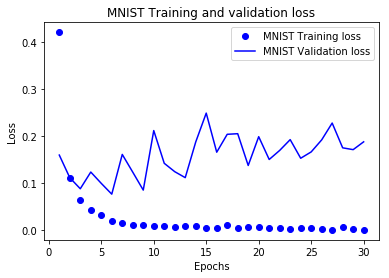

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history

dense_2_loss = history_dict['dense_2_loss']
val_dense_2_loss = history_dict['val_dense_2_loss']

epochs = range(1, len(dense_2_loss) + 1)

plt.plot(epochs, dense_2_loss, 'bo', label = 'MNIST Training loss')
plt.plot(epochs, val_dense_2_loss, 'b', label = 'MNIST Validation loss')
plt.title('MNIST Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

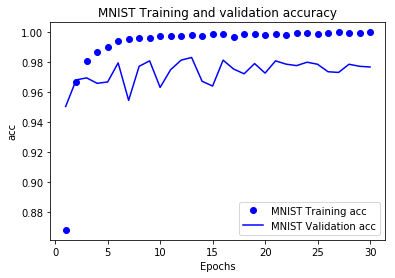

In [13]:
plt.clf()

dense_2_acc = history_dict['dense_2_acc']
val_dense_2_acc = history_dict['val_dense_2_acc']

plt.plot(epochs, dense_2_acc, 'bo', label = 'MNIST Training acc')
plt.plot(epochs, val_dense_2_acc, 'b', label = 'MNIST Validation acc')
plt.title('MNIST Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

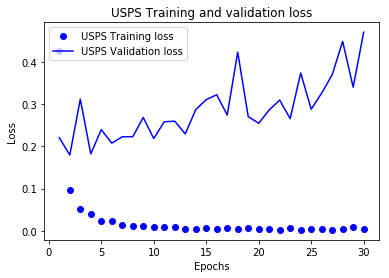

In [14]:
plt.clf()

dense_4_loss = history_dict['dense_4_loss']
val_dense_4_loss = history_dict['val_dense_4_loss']

plt.plot(epochs, dense_4_loss, 'bo', label = 'USPS Training loss')
plt.plot(epochs, val_dense_4_loss, 'b', label = 'USPS Validation loss')
plt.title('USPS Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

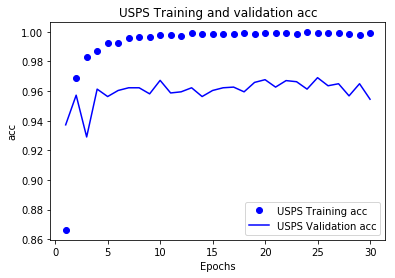

In [15]:
plt.clf()

dense_4_acc = history_dict['dense_4_acc']
val_dense_4_acc = history_dict['val_dense_4_acc']

plt.plot(epochs, dense_4_acc, 'bo', label = 'USPS Training acc')
plt.plot(epochs, val_dense_4_acc, 'b', label = 'USPS Validation acc')
plt.title('USPS Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

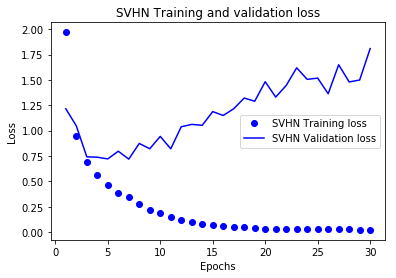

In [16]:
plt.clf()

dense_6_loss = history_dict['dense_6_loss']
val_dense_6_loss = history_dict['val_dense_6_loss']

plt.plot(epochs, dense_6_loss, 'bo', label = 'SVHN Training loss')
plt.plot(epochs, val_dense_6_loss, 'b', label = 'SVHN Validation loss')
plt.title('SVHN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

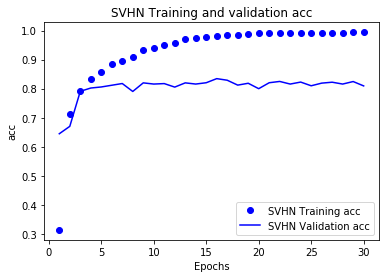

In [17]:
plt.clf()

dense_6_acc = history_dict['dense_6_acc']
val_dense_6_acc = history_dict['val_dense_6_acc']

plt.plot(epochs, dense_6_acc, 'bo', label = 'SVHN Training acc')
plt.plot(epochs, val_dense_6_acc, 'b', label = 'SVHN Validation acc')
plt.title('SVHN Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()